In [1]:
import os.path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, GRU, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer

## Splitting the Data into Characters

The most important part of every data science project is getting the data and transforming it to our required format. Let's grab a poetry dataset:

In [2]:
# original data source: https://www.kaggle.com/johnhallman/complete-poetryfoundationorg-dataset

poems_df = pd.read_csv('data/kaggle_poem_dataset.csv', index_col=0)
poems_df.head()

,Author,Title,Poetry Foundation ID,Content
0,Wendy Videlock,!,55489,"Dear Writers, I’m compiling the first in what ..."
1,Hailey Leithauser,0,41729,"Philosophic\nin its complex, ovoid emptiness,\..."
2,Jody Gladding,1-800-FEAR,57135,We'd like to talk with you about fear t...
3,Joseph Brodsky,1 January 1965,56736,The Wise Men will unlearn your name.\nAbove yo...
4,Ted Berrigan,3 Pages,51624,For Jack Collom\n10 Things I do Every Day\n\np...


Poetry is unique to every author, so we should see if we can find a single author in this dataset with a large collection of poems that we can use to train our models.

In [3]:
poems_df['Author'].value_counts().head()

William Shakespeare      85
Anonymous                82
Alfred, Lord Tennyson    78
Rae Armantrout           62
William Wordsworth       59
Name: Author, dtype: int64

Not too surprising, William Shakespeare is the most frequent author but let's try a close third, Alfred Tennyson:

In [4]:
filtered_poems = poems_df[poems_df['Author'] == "Alfred, Lord Tennyson"]
filtered_poems.head()

,Author,Title,Poetry Foundation ID,Content
1730,"Alfred, Lord Tennyson","Break, Break, Break",45318,"Break, break, break,\nOn thy cold gray stones,..."
2134,"Alfred, Lord Tennyson",The Charge of the Light Brigade,45319,"I\n\nHalf a league, half a league,\nHalf a lea..."
2315,"Alfred, Lord Tennyson",Claribel,45320,Where Claribel low-lieth\nThe breezes pause an...
2687,"Alfred, Lord Tennyson",Crossing the Bar\n \n \n \n Launch Audio in...,45321,"Sunset and evening star,\nAnd one clear call f..."
3529,"Alfred, Lord Tennyson",The Eagle,45322,He clasps the crag with crooked hands;\nClose ...


The poems contain some special characters and to simplify things, we will just replace all non-alpha-numeric characters by a white space:

In [5]:
# the second replace just removes repeated whitespaces
filtered_poems["Content"] = filtered_poems["Content"].str.replace(r"[^a-zA-Z]", " ").str.replace(r"\s+", " ")

<ipython-input-5-df243f72b073>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  filtered_poems["Content"] = filtered_poems["Content"].str.replace(r"[^a-zA-Z]", " ").str.replace(r"\s+", " ")
<ipython-input-5-df243f72b073>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_poems["Content"] = filtered_poems["Content"].str.replace(r"[^a-zA-Z]", " ").str.replace(r"\s+", " ")


Let's build a dataset of the poems. First, we will use the `Tokenizer` class from Tensorflow to preprocess the poems by performing the following steps:
1. Break each poem into a sequence of characters, and
2. Index the characters by numbers and map the character sequences.

We set the following parameters:
- `char_level=True` to tokenize by characters and not words (which is the default), and 
- `lower=True` to put all characters to lower case.

In [6]:
tokenizer = Tokenizer(char_level=True, lower=True)
tokenizer.fit_on_texts(filtered_poems['Content'])

Now, we can extract the most important information from the tokenizer: the two dictionaries that map characters to numbers and numbers back to characters.

In [7]:
char_to_number = tokenizer.word_index
number_to_char = tokenizer.index_word

all_chars = list(char_to_number.keys())

We can see below our characters and their assigned indices:

In [8]:
char_to_number

{' ': 1,
 'e': 2,
 't': 3,
 'a': 4,
 'o': 5,
 'h': 6,
 'n': 7,
 'r': 8,
 'i': 9,
 's': 10,
 'l': 11,
 'd': 12,
 'w': 13,
 'm': 14,
 'u': 15,
 'f': 16,
 'g': 17,
 'y': 18,
 'c': 19,
 'b': 20,
 'p': 21,
 'k': 22,
 'v': 23,
 'q': 24,
 'z': 25,
 'x': 26,
 'j': 27}

The overall counts for each character is also stored and we can look at the top-10 most frequent ones:

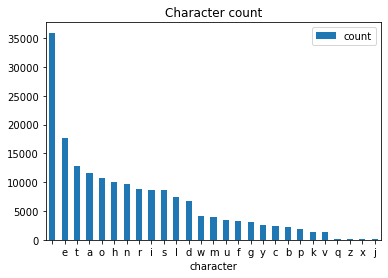

In [9]:
character_frequency = pd.DataFrame(data=tokenizer.word_counts.items(), columns=["character", "count"])
character_frequency = character_frequency.sort_values("count", ascending=False)

character_frequency.set_index("character").plot(kind="bar", rot=0, title="Character count");

Finally, we can use the `texts_to_sequences` method of the tokenizer object to transform the raw text to sequences of indices:

In [10]:
dataset = tokenizer.texts_to_sequences(filtered_poems["Content"])

In [11]:
# This is the first poem in our dataset, with its characters mapped to indices
print(dataset[0])

[20, 8, 2, 4, 22, 1, 20, 8, 2, 4, 22, 1, 20, 8, 2, 4, 22, 1, 5, 7, 1, 3, 6, 18, 1, 19, 5, 11, 12, 1, 17, 8, 4, 18, 1, 10, 3, 5, 7, 2, 10, 1, 5, 1, 10, 2, 4, 1, 4, 7, 12, 1, 9, 1, 13, 5, 15, 11, 12, 1, 3, 6, 4, 3, 1, 14, 18, 1, 3, 5, 7, 17, 15, 2, 1, 19, 5, 15, 11, 12, 1, 15, 3, 3, 2, 8, 1, 3, 6, 2, 1, 3, 6, 5, 15, 17, 6, 3, 10, 1, 3, 6, 4, 3, 1, 4, 8, 9, 10, 2, 1, 9, 7, 1, 14, 2, 1, 5, 1, 13, 2, 11, 11, 1, 16, 5, 8, 1, 3, 6, 2, 1, 16, 9, 10, 6, 2, 8, 14, 4, 7, 1, 10, 1, 20, 5, 18, 1, 3, 6, 4, 3, 1, 6, 2, 1, 10, 6, 5, 15, 3, 10, 1, 13, 9, 3, 6, 1, 6, 9, 10, 1, 10, 9, 10, 3, 2, 8, 1, 4, 3, 1, 21, 11, 4, 18, 1, 5, 1, 13, 2, 11, 11, 1, 16, 5, 8, 1, 3, 6, 2, 1, 10, 4, 9, 11, 5, 8, 1, 11, 4, 12, 1, 3, 6, 4, 3, 1, 6, 2, 1, 10, 9, 7, 17, 10, 1, 9, 7, 1, 6, 9, 10, 1, 20, 5, 4, 3, 1, 5, 7, 1, 3, 6, 2, 1, 20, 4, 18, 1, 4, 7, 12, 1, 3, 6, 2, 1, 10, 3, 4, 3, 2, 11, 18, 1, 10, 6, 9, 21, 10, 1, 17, 5, 1, 5, 7, 1, 3, 5, 1, 3, 6, 2, 9, 8, 1, 6, 4, 23, 2, 7, 1, 15, 7, 12, 2, 8, 1, 3, 6, 2, 1, 6, 9, 11, 

## Extracting windows for next-character prediction

Let's discuss what we have so far. We have a data collection where each element is a poem, split up into a list of characters and indexed by numbers. Our plan is build a model that will predict the next character based on previous ones. So, we want to transform this into a dataset $X$ and $y$, where each data point $x_i$ is a window of consecutive characters and $y_i$ is the next character immediately after the window.

Suppose we decided on a sequence length of 10, and we explored the first poem:

```
Break, break, break,
On thy cold gray stones, O Sea!
And I would that my tongue could utter
The thoughts that arise in me.

O, well for the fisherman's boy,
That he shouts with his sister at play!
O, well for the sailor lad,
That he sings in his boat on the bay!

And the stately ships go on
To their haven under the hill;
But O for the touch of a vanish'd hand,
And the sound of a voice that is still!

Break, break, break
At the foot of thy crags, O Sea!
But the tender grace of a day that is dead
Will never come back to me.
```


We would like our dataset to look like this:

$x_0$: `Break, bre`<br>
$y_0$: `a`

$x_1$: `reak, brea`<br>
$y_1$: `k`

$x_2$: `eak, break`<br>
$y_2$: `,`

$\vdots$


<img src="http://drive.google.com/uc?export=view&id=14gfhWtJrASB3NBSnZnARSbLA6vjXcGkt" height=400 width=600></img>


The following code achieves exactly this:

In [12]:
# sliding window
SEQUENCE_LENGTH = 10

X = []
y = []

for poem in dataset:
    for window_start_idx in range(len(poem)-SEQUENCE_LENGTH):
        window_end_idx = window_start_idx + SEQUENCE_LENGTH
        X.append(poem[window_start_idx: window_end_idx])
        y.append(poem[window_end_idx])

X = np.array(X)
y = np.array(y)

# Let's look at the shapes
print(X.shape)
print(y.shape)

(178275, 10)
(178275,)


Let's inspect our $X$ and $y$:

In [13]:
for i in range(5):
    print("X:", X[i])
    print("y:", y[i])
    print("*******")

X: [20  8  2  4 22  1 20  8  2  4]
y: 22
*******
X: [ 8  2  4 22  1 20  8  2  4 22]
y: 1
*******
X: [ 2  4 22  1 20  8  2  4 22  1]
y: 20
*******
X: [ 4 22  1 20  8  2  4 22  1 20]
y: 8
*******
X: [22  1 20  8  2  4 22  1 20  8]
y: 2
*******


As a sanity check, we can back-transform the indices to letters:

In [14]:
for i in range(5):
    print("X:", [number_to_char[num] for num in X[i]])
    print("y:", number_to_char[y[i]])
    print("*******")

X: ['b', 'r', 'e', 'a', 'k', ' ', 'b', 'r', 'e', 'a']
y: k
*******
X: ['r', 'e', 'a', 'k', ' ', 'b', 'r', 'e', 'a', 'k']
y:  
*******
X: ['e', 'a', 'k', ' ', 'b', 'r', 'e', 'a', 'k', ' ']
y: b
*******
X: ['a', 'k', ' ', 'b', 'r', 'e', 'a', 'k', ' ', 'b']
y: r
*******
X: ['k', ' ', 'b', 'r', 'e', 'a', 'k', ' ', 'b', 'r']
y: e
*******


## Train and Validation data

We're going to split the data into train and validation sets. We don't need a test set here because we don't need a perfect unbiased estimate of how our model will perform on new data, (our unbiased estimate will come from using the trained model to generate some new poetry), but we'll use the validation set to monitor how the training is progressing.

In [15]:
from sklearn.model_selection import train_test_split

# split train and validation set
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.1)

In [16]:
print(X_train.shape, y_train.shape)      
print(X_validation.shape, y_validation.shape)

(160447, 10) (160447,)
(17828, 10) (17828,)


## Embedding layers 

Our data has the right shape but it would not be right to feed it into the model as is. Currently, we indexed the characters with numbers but this assignment was completely arbitrary. At the same time, the model would interpret characters with nearby index as similar. This is exactly why we generally use one-hot encoding for categorical features. That would be a legitimate approach here as well but if our vocabulary increases (the number of words in a language model could be tens of thousands), we would get incredibly high-dimensional vectors. 

The way to solve this issue is to use **embedding layers**. At initialization, these layers assign a random, relatively low dimensional vector to each possible index (we can specify this dimension). During training, the model adjusts these embeddings to increase its performance (the embedding layers are part of the calculation graph and the gradients are applied to them as well). This training often results in semantically similar or co-occurring words to be embedded close to one another. 

This is very much in line with the word2vec embeddings, but in that approach, the embeddings were trained without a downstream task in mind.

Let's see how the Tensorflow implementation works. One technical point here is that since our indexing started with 1, the number of classes for the embedding layer should be set to the number of characters plus 1.

In [17]:
number_of_classes = len(all_chars) + 1
embedding_dim = 8

# initilize an embedding layer
embedding_layer = Embedding(number_of_classes, embedding_dim) 

In [18]:
one_window = X[0] # shape: (10) 

embedding_layer(one_window).numpy() # shape: (10, embedding_dim)

array([[-0.02431475, -0.03901017,  0.03295299, -0.02117788,  0.00443778,
        -0.01010213,  0.04645221,  0.04154441],
       [-0.03232659, -0.04370606, -0.0181713 ,  0.04520538,  0.00268134,
        -0.03808061, -0.02351   , -0.04108705],
       [ 0.01658553,  0.00534139, -0.03375756,  0.00741417,  0.00015374,
        -0.02286609,  0.01805489, -0.0062876 ],
       [ 0.01618527, -0.02113792,  0.04027298,  0.04849551, -0.00702187,
         0.01884365,  0.00735608, -0.03843516],
       [ 0.04832562, -0.02472485,  0.02315504, -0.0309687 ,  0.04130283,
         0.03642601, -0.03711957, -0.03910987],
       [ 0.03318104,  0.03017921, -0.03057911,  0.02920147, -0.00733055,
        -0.02937546,  0.00887788, -0.00527619],
       [-0.02431475, -0.03901017,  0.03295299, -0.02117788,  0.00443778,
        -0.01010213,  0.04645221,  0.04154441],
       [-0.03232659, -0.04370606, -0.0181713 ,  0.04520538,  0.00268134,
        -0.03808061, -0.02351   , -0.04108705],
       [ 0.01658553,  0.00534139

We specified 8-dimensional embeddings so these are hard to visualize but we can apply PCA to reduce them to two dimensions and plot them:

In [19]:
from sklearn.decomposition import PCA

all_embeddings = embedding_layer(np.arange(number_of_classes))

pca = PCA(n_components=2)

all_embeddings_2d = pca.fit_transform(all_embeddings)

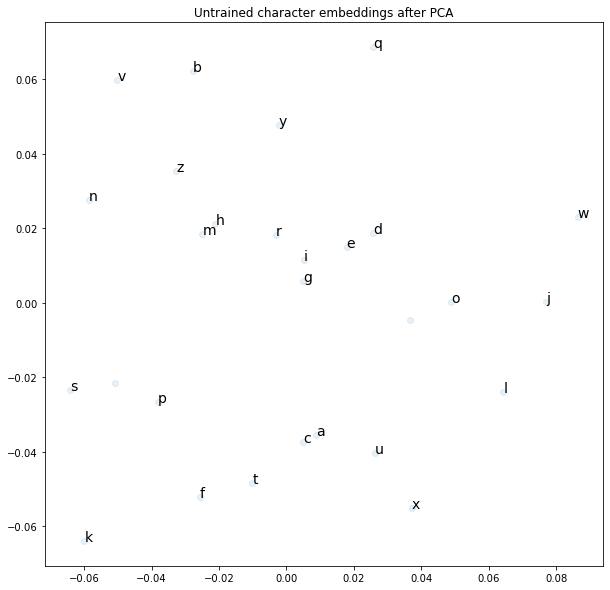

In [20]:
plt.figure(figsize=(10, 10))

# plot the PCA components
plt.scatter(all_embeddings_2d[:, 0], all_embeddings_2d[:, 1], alpha=0.1)

# add characters to the plot
for num, char in number_to_char.items():
    plt.text(all_embeddings_2d[num, 0], all_embeddings_2d[num, 1], char, fontsize=14)

plt.title("Untrained character embeddings after PCA")
plt.show()

As expected, the untrained embeddings look rather random.

## Single-layer RNN

Our character-level language model will consist of: 
- an embedding layer that produces 8-dimensional character-vectors,
- a single LSTM layer with 128 units,
- a dense hidden layer with 64 units, and
- an output layer.

The model will aim to predict the next character based on the input, so the final layer should return probabilities over the possible characters (hence the softmax activation). The LSTM and dense layers are followed by batch normalization layers that help the learning process.

In [21]:
RNN_charlevel = Sequential()
RNN_charlevel.add(Embedding(number_of_classes, 8))

RNN_charlevel.add(LSTM(128, activation='relu', return_sequences=False))
RNN_charlevel.add(BatchNormalization())

RNN_charlevel.add(Dense(64, activation='relu'))
RNN_charlevel.add(BatchNormalization())

RNN_charlevel.add(Dense(number_of_classes, activation='softmax'))

In [22]:
# Compile model
RNN_charlevel.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(lr=0.001),
    metrics=['accuracy']
)

In [23]:
# Display its summary
RNN_charlevel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 8)           224       
_________________________________________________________________
lstm (LSTM)                  (None, 128)               70144     
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 28)                1820      
Total params: 81,212
Trainable params: 80,828
Non-trainable params: 384
__________________________________________________

In [24]:
history = RNN_charlevel.fit(X_train, y_train,
        batch_size=1024,
        epochs=20,
        validation_data=(X_validation, y_validation))

Epoch 1/20
157/157 [==============================] - 15s 93ms/step - loss: 2.4247 - accuracy: 0.3266 - val_loss: 3.0257 - val_accuracy: 0.1006
Epoch 2/20
157/157 [==============================] - 13s 83ms/step - loss: 2.0389 - accuracy: 0.3941 - val_loss: 2.8470 - val_accuracy: 0.1203
Epoch 3/20
157/157 [==============================] - 14s 88ms/step - loss: 1.9427 - accuracy: 0.4138 - val_loss: 2.6255 - val_accuracy: 0.2037
Epoch 4/20
157/157 [==============================] - 13s 83ms/step - loss: 1.8896 - accuracy: 0.4267 - val_loss: 2.1574 - val_accuracy: 0.3515
Epoch 5/20
157/157 [==============================] - 12s 76ms/step - loss: 1.8525 - accuracy: 0.4347 - val_loss: 1.9681 - val_accuracy: 0.3941
Epoch 6/20
157/157 [==============================] - 12s 76ms/step - loss: 1.8203 - accuracy: 0.4432 - val_loss: 1.9126 - val_accuracy: 0.4054
Epoch 7/20
157/157 [==============================] - 12s 76ms/step - loss: 1.7969 - accuracy: 0.4488 - val_loss: 1.8640 - val_accuracy:

Looking at the training metrics, we see that the validation and training loss decrease in parallel (so we are not overfitting), and at the end of the 20th epoch, we achieve around 50% accuracy. 

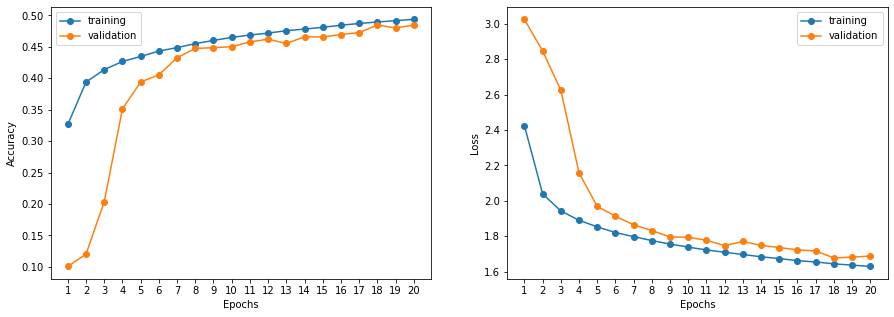

In [25]:
epochs = range(1, 21)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history["accuracy"], label="training", marker="o")
plt.plot(epochs, history.history["val_accuracy"], label="validation", marker="o")
plt.xlabel("Epochs")
plt.xticks(epochs)
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history["loss"], label="training", marker="o")
plt.plot(epochs, history.history["val_loss"], label="validation", marker="o")
plt.xlabel("Epochs")
plt.xticks(epochs)
plt.ylabel("Loss")
plt.legend()
plt.show()

Since we are more interested in realistic text generation rather than accuracy, we shall examine that next. We will _seed_ the model with a sentence and extend that character-by-character. To do that, we feed the last ten characters of the current text into the model and sample the next character using the probabilities that the model outputs. We repeat this process 200 times, extending the seed-text with 200 new characters.

In [26]:
input_phrase = ["To be or not to be."]

# process for the model
processed_phrase = tokenizer.texts_to_sequences(input_phrase)[0]

for i in range(200):
    # extract last 10 characters
    network_input = np.array(processed_phrase[-SEQUENCE_LENGTH:], dtype=np.float32)
    network_input = network_input.reshape((1, SEQUENCE_LENGTH)) # shape: 1 x 10

    # the RNN gives the probability of each character as the next one
    predict_proba = RNN_charlevel.predict(network_input)[0]
    
    # sample the characters using these chances
    predicted_index = np.random.choice(number_of_classes, 1, p=predict_proba)[0]

    # add new index at the end of our list
    processed_phrase.append(predicted_index)
    
    # progress indicator
    print(i, end="\r")

# map indices to characters and join into single string
output_phrase = "".join([number_to_char.get(number, "") for number in processed_phrase])    

print(output_phrase)



to be or not to be teper d shans and bove for at neclot from theses wunne the my on who leys in such apnies theresonce in in oning tros thou is thure gloft a string and kee goat yiver strid d seep on her star no the an


If you rerun the cell, you will see that the output varies. Overall the model managed to produce words that look fairly close to English, with a few shorter words which are actually proper English terms.

---
We can check now how the trained embeddings look for each character. As before, we use PCA to reduce the 8-dimensional vectors to 2 dimensions before plotting. Your task is to extract the trained embedding layer from the RNN model.

In [27]:
RNN_charlevel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 8)           224       
_________________________________________________________________
lstm (LSTM)                  (None, 128)               70144     
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 28)                1820      
Total params: 81,212
Trainable params: 80,828
Non-trainable params: 384
__________________________________________________

In [29]:
RNN_charlevel.layers[0]

In [32]:
trained_embedding_layer = RNN_charlevel.layers[0]

all_embeddings = trained_embedding_layer(np.arange(number_of_classes))

pca = PCA(n_components=2)

all_embeddings_2d = pca.fit_transform(all_embeddings)

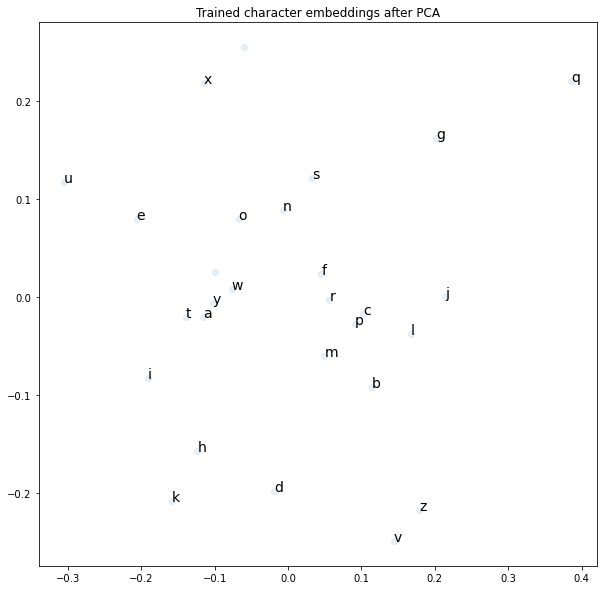

In [33]:
plt.figure(figsize=(10, 10))

plt.scatter(all_embeddings_2d[:, 0], all_embeddings_2d[:, 1], alpha=0.1)
for num, char in number_to_char.items():
    plt.text(all_embeddings_2d[num, 0], all_embeddings_2d[num, 1], char, fontsize=14)

plt.title("Trained character embeddings after PCA")
plt.show()

- What can you say from looking at the results? 
- What are the points without labels?

---

## Word-level text generation 

Next, we shall repeat a similar process but now feeding in the text word-by-word. This means that our vocabulary will be much bigger but our model will at least output proper English words. To do this, we set `char_level=False` when initializing the tokenizer.

In [35]:
# Note: char_level is False now
tokenizer = Tokenizer(char_level=False, lower=True) 
tokenizer.fit_on_texts(filtered_poems['Content'])

In [36]:
word_to_number = tokenizer.word_index
number_to_word = tokenizer.index_word

all_words = list(word_to_number.keys())

print(f"Vocabulary size: {len(all_words)}")

Vocabulary size: 4854


In [37]:
dataset = tokenizer.texts_to_sequences(filtered_poems["Content"])

In [38]:
# This is the first poem in the dataset, displayed using its word numbers
print(dataset[0])

[488, 488, 488, 20, 27, 232, 375, 1291, 28, 151, 2, 8, 103, 9, 11, 1047, 271, 864, 1, 758, 9, 664, 6, 17, 28, 140, 14, 1, 2576, 29, 537, 9, 22, 1292, 10, 19, 2577, 36, 665, 28, 140, 14, 1, 2578, 759, 9, 22, 865, 6, 19, 538, 20, 1, 1722, 2, 1, 666, 1293, 152, 20, 4, 62, 1723, 318, 1, 866, 13, 28, 14, 1, 254, 3, 5, 867, 7, 141, 2, 1, 342, 3, 5, 144, 9, 12, 186, 488, 488, 488, 36, 1, 539, 3, 27, 1724, 28, 151, 13, 1, 540, 541, 3, 5, 63, 9, 12, 93, 56, 159, 113, 233, 4, 17]


Now, we construct the training data by sliding a window of length 5 over the words:

<img src="http://drive.google.com/uc?export=view&id=14hxGUoapWuZmqlLrRJZ8-oTA2uS5APxI" height=400 width=600></img>

The code is exactly the same as before, we just use a smaller window to save some time on computation:

In [39]:
# sliding window
SEQUENCE_LENGTH = 5

X = []
y = []

for poem in dataset:
    for window_start_idx in range(len(poem)-SEQUENCE_LENGTH):
        window_end_idx = window_start_idx + SEQUENCE_LENGTH
        X.append(poem[window_start_idx: window_end_idx])
        y.append(poem[window_end_idx])

X = np.array(X)
y = np.array(y)

# Let's look at the shapes
print(X.shape)
print(y.shape)

(35555, 5)
(35555,)


Let's inspect our $X$ and $y$

In [40]:
for i in range(5):
    print("X:", X[i])
    print("y:", y[i])
    print("*******")

X: [488 488 488  20  27]
y: 232
*******
X: [488 488  20  27 232]
y: 375
*******
X: [488  20  27 232 375]
y: 1291
*******
X: [  20   27  232  375 1291]
y: 28
*******
X: [  27  232  375 1291   28]
y: 151
*******


In [41]:
for i in range(5):
    print("X:", [number_to_word[num] for num in X[i]])
    print("y:", number_to_word[y[i]])
    print("*******")

X: ['break', 'break', 'break', 'on', 'thy']
y: cold
*******
X: ['break', 'break', 'on', 'thy', 'cold']
y: gray
*******
X: ['break', 'on', 'thy', 'cold', 'gray']
y: stones
*******
X: ['on', 'thy', 'cold', 'gray', 'stones']
y: o
*******
X: ['thy', 'cold', 'gray', 'stones', 'o']
y: sea
*******


With our new data, we need to repeat the train-test split as well:

In [42]:
# split train and validation set
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.1)

In [43]:
print(X_train.shape, y_train.shape)      
print(X_validation.shape, y_validation.shape)

(31999, 5) (31999,)
(3556, 5) (3556,)


## Deep recurrent neural networks

For our word-level language model, we will use two recurrent layers before the dense and output layers. The motivation behind this is that with more layers, the model can learn more complex relationships between the preceding words. Note that the first layer returns the output for all steps of the sequence, while the second (last) recurrent layer only passes the final output.

To speed up computation, we use GRU units instead of LSTMs and add dropout to avoid heavily overfitting on the training data.

In [44]:
number_of_classes = len(all_words)+1

RNN_wordlevel = Sequential()
RNN_wordlevel.add(Embedding(number_of_classes, 8))

# the intermediate recurrent layers should return full sequences
RNN_wordlevel.add(GRU(64, activation='relu', return_sequences=True))
RNN_wordlevel.add(BatchNormalization())
RNN_wordlevel.add(Dropout(0.15))

# the last recurrent layer only returns the final output
RNN_wordlevel.add(GRU(32, activation='relu', return_sequences=False))
RNN_wordlevel.add(BatchNormalization())
RNN_wordlevel.add(Dropout(0.15))

RNN_wordlevel.add(Dense(16, activation='relu'))
RNN_wordlevel.add(BatchNormalization())
RNN_wordlevel.add(Dropout(0.15))

RNN_wordlevel.add(Dense(number_of_classes, activation='softmax'))

In [45]:
# Compile model
RNN_wordlevel.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(lr=0.001),
    metrics=['accuracy']
)

In [46]:
# Display its summary
RNN_wordlevel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 8)           38840     
_________________________________________________________________
gru (GRU)                    (None, None, 64)          14208     
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 64)          256       
_________________________________________________________________
dropout (Dropout)            (None, None, 64)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                9408      
_________________________________________________________________
batch_normalization_3 (Batch (None, 32)                128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)               

Note that the final layer is learning a probability distribution over ~5K possible words, a rather hard task given only ~150K training data points and the large variability in natural language. 

In [47]:
history = RNN_wordlevel.fit(X_train, y_train,
        batch_size=1024,
        epochs=25,
        validation_data=(X_validation, y_validation))

Epoch 1/25
32/32 [==============================] - 3s 101ms/step - loss: 8.4694 - accuracy: 0.0030 - val_loss: 8.4582 - val_accuracy: 8.4364e-04
Epoch 2/25
32/32 [==============================] - 3s 92ms/step - loss: 8.3966 - accuracy: 0.0297 - val_loss: 8.4290 - val_accuracy: 8.4364e-04
Epoch 3/25
32/32 [==============================] - 3s 94ms/step - loss: 8.2807 - accuracy: 0.0590 - val_loss: 8.3961 - val_accuracy: 0.0464
Epoch 4/25
32/32 [==============================] - 3s 95ms/step - loss: 8.0907 - accuracy: 0.0783 - val_loss: 8.3553 - val_accuracy: 0.0464
Epoch 5/25
32/32 [==============================] - 3s 97ms/step - loss: 7.8313 - accuracy: 0.0885 - val_loss: 8.2958 - val_accuracy: 0.0506
Epoch 6/25
32/32 [==============================] - 3s 96ms/step - loss: 7.5314 - accuracy: 0.0957 - val_loss: 8.1765 - val_accuracy: 0.0748
Epoch 7/25
32/32 [==============================] - 4s 117ms/step - loss: 7.2136 - accuracy: 0.1004 - val_loss: 8.0070 - val_accuracy: 0.0627
Epo

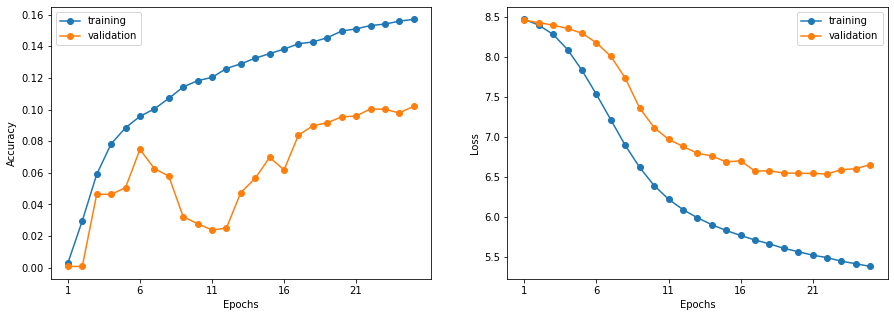

In [48]:
epochs = range(1, 26)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history["accuracy"], label="training", marker="o")
plt.plot(epochs, history.history["val_accuracy"], label="validation", marker="o")
plt.xlabel("Epochs")
plt.xticks(epochs[::5])
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history["loss"], label="training", marker="o")
plt.plot(epochs, history.history["val_loss"], label="validation", marker="o")
plt.xlabel("Epochs")
plt.xticks(epochs[::5])
plt.ylabel("Loss")
plt.legend()
plt.show()

Finally, we use the same loop as before to generate text:

In [54]:
input_phrase = "dear sir I heard you like the wind"

# process for the model
processed_phrase = tokenizer.texts_to_sequences([input_phrase])[0]

for i in range(50):
    # extract last 5 words
    network_input = np.array(processed_phrase[-SEQUENCE_LENGTH:], dtype=np.float32)
    network_input = network_input.reshape((1, SEQUENCE_LENGTH)) # shape: 1 x 5

    # the RNN gives the probability of each word as the next one
    predict_proba = RNN_wordlevel.predict(network_input)[0] # shape (4855,)
    
    # sample one word using these chances
    predicted_index = np.random.choice(number_of_classes, 1, p=predict_proba)[0]

    # add new index at the end of our list
    processed_phrase.append(predicted_index)
    
    # progress indicator
    print(i, end="\r")

# indices mapped to words - the method expects a list of lists so we need the extra bracket
output_phrase = tokenizer.sequences_to_texts([processed_phrase])[0]

print(output_phrase)

dear sir i heard you like the wind double knight cold i fool some overlaid with peak shouting and mute hast face with kay me aidless their pavement robed all thorn apollo deeds won between the uncle deeps he no better freely look d body eating with the eyes s gray fur about not we know my murmurest


The result would probably not fool a human since the model failed to learn grammar with so little training. We can take a look at the word embeddings now and see if we notice any patterns:

In [51]:
trained_embedding = RNN_wordlevel.layers[0]

all_embeddings = trained_embedding(np.arange(number_of_classes))

pca = PCA(n_components=2)

all_embeddings_2d = pca.fit_transform(all_embeddings)

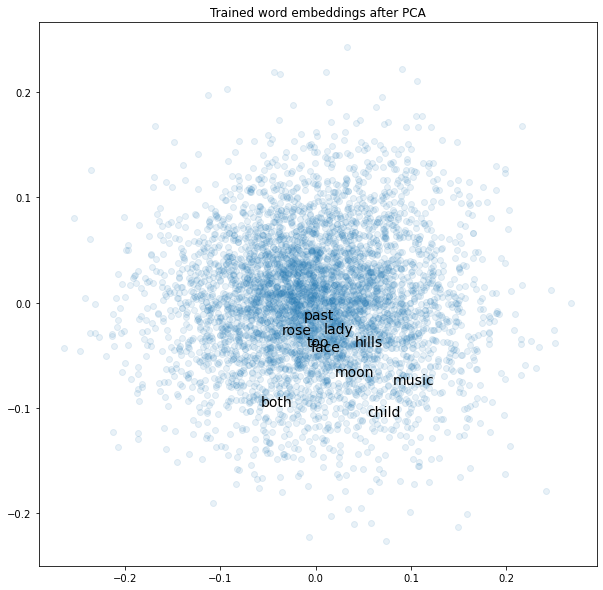

In [52]:
plt.figure(figsize=(10, 10))


plt.scatter(all_embeddings_2d[:, 0], all_embeddings_2d[:, 1], alpha=0.1)

# we select a few words based on frequency
sorted_words = sorted(tokenizer.word_counts.items(), key=lambda x: x[1])
word_sample = sorted_words[-300: -100: 20]

for word, num in word_sample:
    # some noise is added to the text position to avoid accidental overlapping
    # rerun the cell if too many words overlap
    plt.text(all_embeddings_2d[num, 0]+np.random.randn(1)*0.01, 
             all_embeddings_2d[num, 1]+np.random.randn(1)*0.01,
             word, 
             fontsize=14)

plt.title("Trained word embeddings after PCA")
plt.show()

---
Use the last word-level RNN model we trained to generate another poem starting with the phrase below. You can take advantage of the scripts we used earlier.


In [56]:
input_phrase = "dear sir I heard you like the sea"

# YOUR CODE COMES HERE
# process for the model
processed_phrase = tokenizer.texts_to_sequences([input_phrase])[0]

for i in range(50):
    # extract last 5 words
    network_input = np.array(processed_phrase[-SEQUENCE_LENGTH:], dtype=np.float32)
    network_input = network_input.reshape((1, SEQUENCE_LENGTH)) # shape: 1 x 5

    # the RNN gives the probability of each word as the next one
    predict_proba = RNN_wordlevel.predict(network_input)[0] # shape (4855,)
    
    # sample one word using these chances
    predicted_index = np.random.choice(number_of_classes, 1, p=predict_proba)[0]

    # add new index at the end of our list
    processed_phrase.append(predicted_index)
    
    # progress indicator
    print(i, end="\r")

# indices mapped to words - the method expects a list of lists so we need the extra bracket
output_phrase = tokenizer.sequences_to_texts([processed_phrase])[0]

print(output_phrase)

dear sir i heard you like the sea peacock the pinnacles with blow crow to shalott the grasshopper is to thy drowsy doy comes arm have hardly ilion the realms s embrace moy chasms with hunter d vessel over thy doze soon sir bedivere himself her inward for mark to sweetly she were my feast yourself thee lighted
